Implementing Grid Search on keras, based on this <a href="https://machinelearningmastery.com/grid-search-hyperparameters-deep-learning-models-python-keras/"> tutorial</a> 

In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.datasets import load_iris
from sklearn.model_selection import GridSearchCV
from tensorflow import keras
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df = pd.read_csv("horizon_unpivot.csv")
df = df.dropna()

In [3]:
features = ['opp_goal_difference_last', 'ha', 'opp_goal_difference_5MA', 'opp_goal_difference_10MA',
       'since_last_win', 'goal_difference_5MA', 'goal_difference_10MA', 'goal_difference_last',
        'yellow_cards_referee_hist','odds_5MA', 'odds_10MA', 'odds_last']

In [4]:
df["class_var"] = np.where(df["goal_difference"].gt(1),1, 0)

In [5]:
df["ha"] = np.where(df["ha"].eq("h"),1,0)

In [6]:
df = df.loc[:, features + ["class_var"]]

df = df.sample(frac=1)

fraud_df = df.loc[df['class_var'] == 1]
non_fraud_df = df.loc[df['class_var'] == 0][:len(fraud_df)]

normal_distributed_df = pd.concat([fraud_df, non_fraud_df])

# Shuffle dataframe rows
new_df = normal_distributed_df.sample(frac=1, random_state=42)

new_df.head()

,opp_goal_difference_last,ha,opp_goal_difference_5MA,opp_goal_difference_10MA,since_last_win,goal_difference_5MA,goal_difference_10MA,goal_difference_last,yellow_cards_referee_hist,odds_5MA,odds_10MA,odds_last,class_var
3378,0.0,0,0.6,0.300000,3.0,-0.6,-0.500000,0.0,5.000,3.390,4.137000,3.90,0
1747,-1.0,1,-1.8,-1.800000,2.0,-0.2,-0.200000,-2.0,3.000,4.916,4.916000,3.10,1
2651,0.0,0,1.2,0.555556,1.0,0.4,0.111111,0.0,4.000,2.314,3.062222,1.83,0
1799,0.0,1,-0.2,-0.600000,5.0,-1.4,-0.400000,-1.0,4.400,6.250,4.770000,11.00,1
1443,0.0,0,0.6,0.200000,2.0,-0.4,-0.500000,0.0,3.625,3.460,3.975000,3.70,0


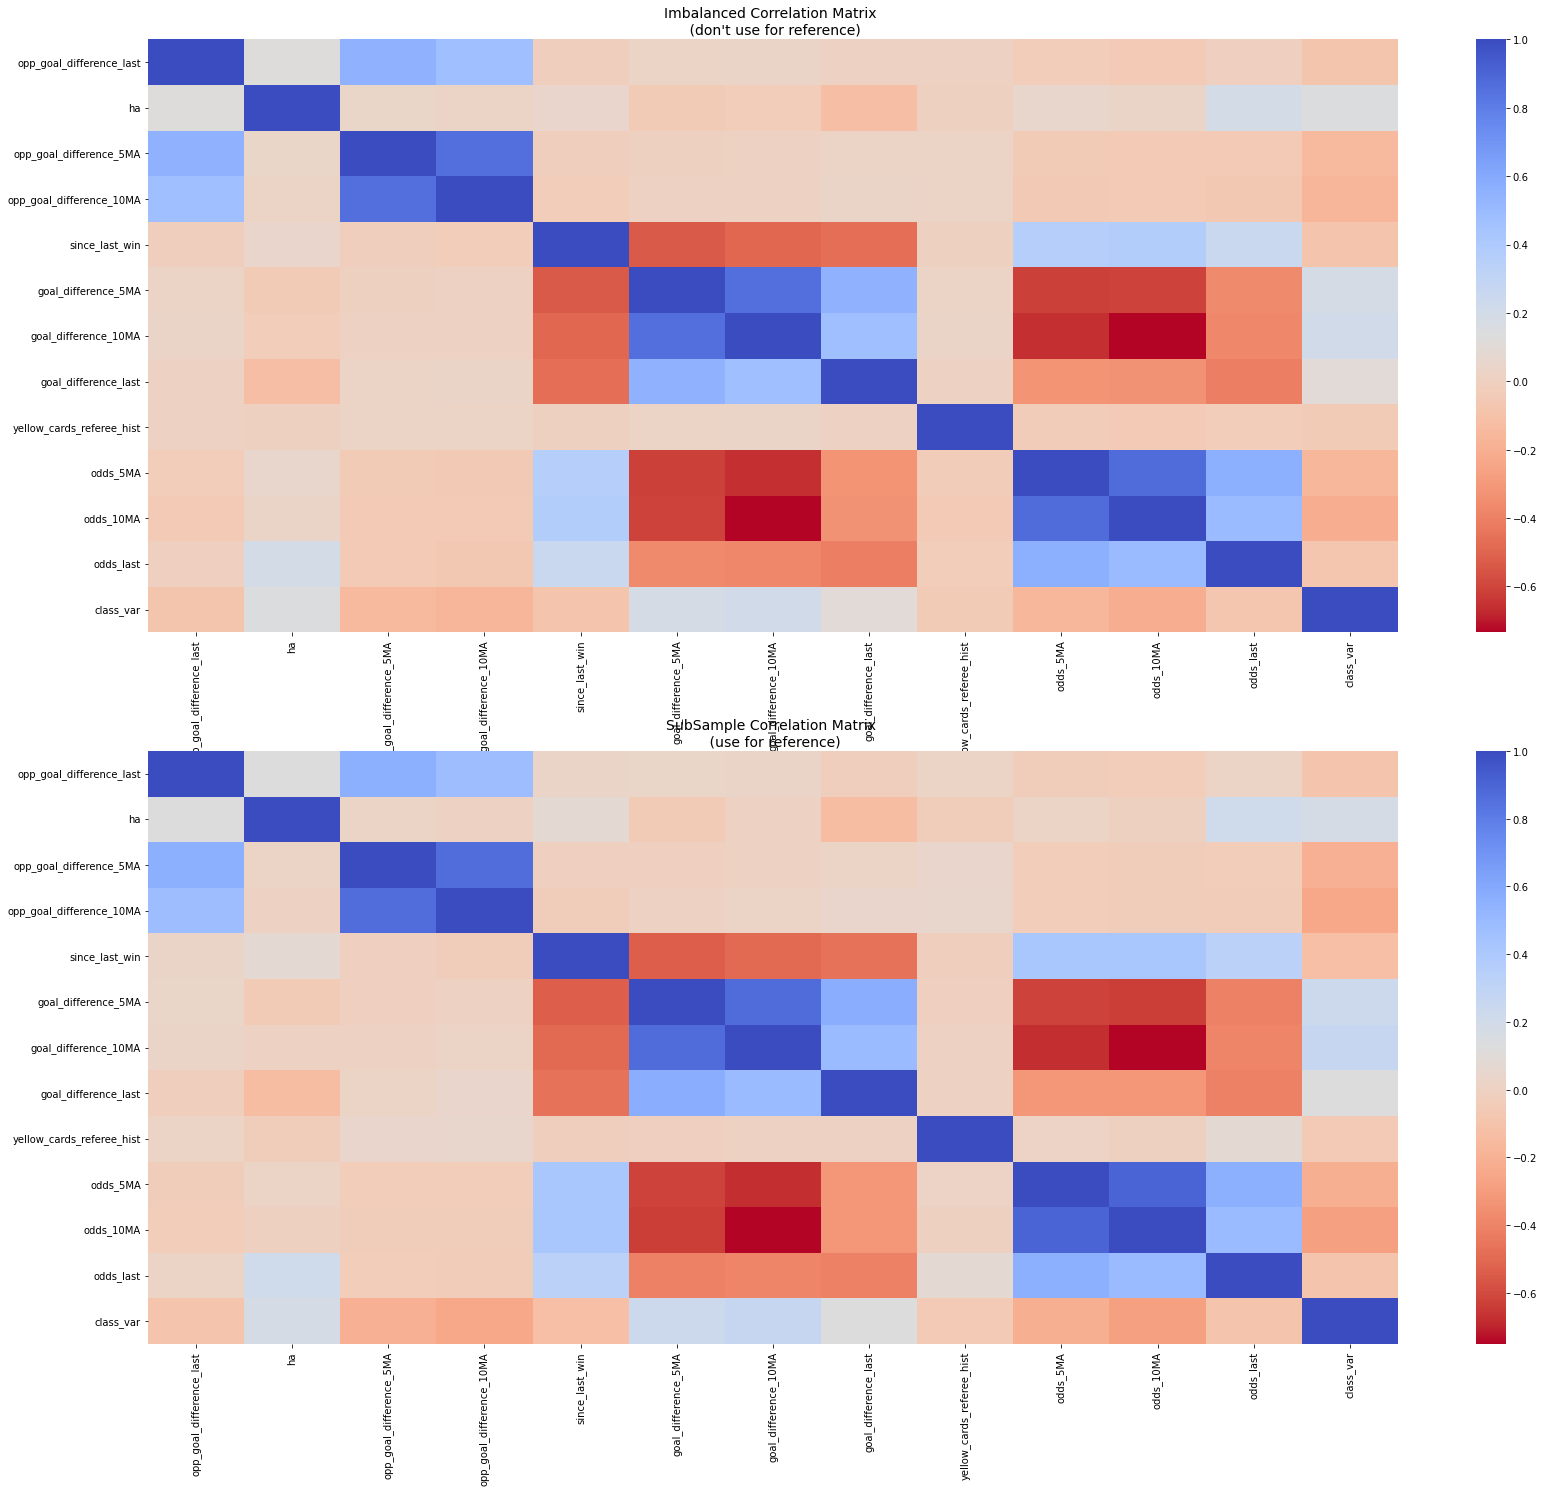

In [7]:
f, (ax1,ax2) = plt.subplots(2, 1, figsize=(28,24))

corr = df.corr()
sns.heatmap(corr, cmap='coolwarm_r', annot_kws={'size':20}, ax=ax1)
ax1.set_title("Imbalanced Correlation Matrix \n (don't use for reference)", fontsize=14)

sub_sample_corr = new_df.corr()
sns.heatmap(sub_sample_corr, cmap='coolwarm_r', annot_kws={'size':20}, ax=ax2)
ax2.set_title('SubSample Correlation Matrix \n (use for reference)', fontsize=14)

plt.show()

In [8]:
to_be_adjusted = sub_sample_corr["class_var"].drop("class_var").abs().sort_values()[-5:].index

C:\Users\flis1\Miniconda3\envs\tensorflow\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\flis1\Miniconda3\envs\tensorflow\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\flis1\Miniconda3\envs\tensorflow\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function w

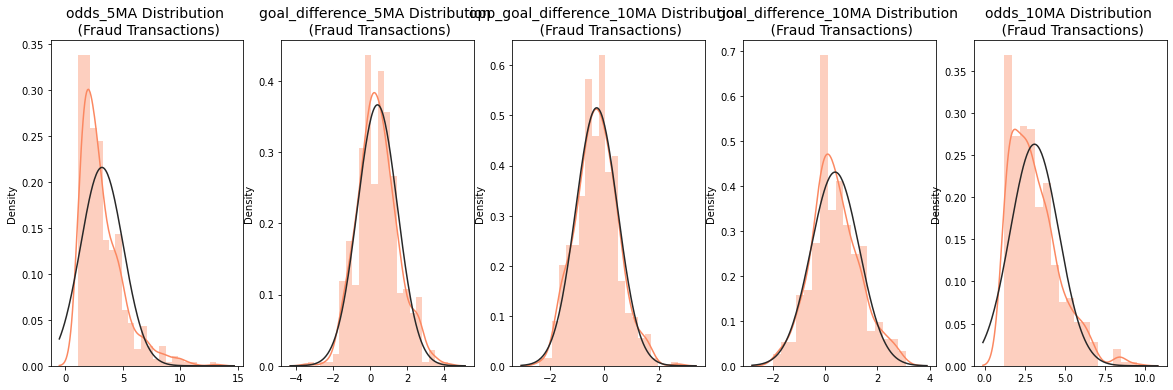

In [9]:
from scipy.stats import norm

f, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(1, 5 , figsize=(20, 6))

available_axes = [ax1, ax2, ax3, ax4, ax5]

for i, attr in enumerate(to_be_adjusted):
    v14_fraud_dist = new_df[attr].loc[new_df['class_var'] == 1].values
    sns.distplot(v14_fraud_dist,ax=available_axes[i], fit=norm, color='#FB8861')
    available_axes[i].set_title(f'{attr} Distribution \n (Fraud Transactions)', fontsize=14)

plt.show()

We scale with the Standard Scaler. That is the features are normalized. Models usually work better when this is the case.

In [10]:
for attr in to_be_adjusted:
    attr_fraud = new_df[attr].loc[new_df['class_var'] == 1].values
    q25, q75 = np.percentile(attr_fraud, 25), np.percentile(attr_fraud, 75)
    attr_iqr = q75 - q25

    attr_cut_off = attr_iqr * 1.5
    attr_lower, attr_upper = q25 - attr_cut_off, q75 + attr_cut_off
    print(f'{attr} Lower: {attr_lower}')
    print(f'{attr} Upper: {attr_upper}')
    outliers = [x for x in attr_fraud if x < attr_lower or x > attr_upper]
    print(f'{attr} outliers: {outliers}')
    print(f'Feature {attr} Outliers for Fraud Cases: {len(outliers)}')
    new_df = new_df.drop(new_df[(new_df[attr] > attr_upper) | (new_df[attr] < attr_lower)].index)
    print(f'Number of Instances after outliers removal: {len(new_df)}')

odds_5MA Lower: -1.448999999999998
odds_5MA Upper: 7.326999999999998
odds_5MA outliers: [9.720000000000002, 8.59, 8.0, 8.28, 10.999999999999998, 7.980000000000001, 7.348000000000001, 7.463999999999999, 9.71, 9.260000000000002, 7.339999999999998, 8.298, 8.669999999999998, 9.82, 13.067999999999998, 10.010000000000002, 10.37, 8.19, 8.959999999999999, 8.578]
Feature odds_5MA Outliers for Fraud Cases: 20
Number of Instances after outliers removal: 968
goal_difference_5MA Lower: -1.9999999999999998
goal_difference_5MA Upper: 2.8
goal_difference_5MA outliers: [3.6, 3.4, 3.4, 3.2, 4.2, 3.0, -2.4, 3.4, -3.4]
Feature goal_difference_5MA Outliers for Fraud Cases: 9
Number of Instances after outliers removal: 947
opp_goal_difference_10MA Lower: -2.3
opp_goal_difference_10MA Upper: 1.7
opp_goal_difference_10MA outliers: [2.7, 1.8, -2.4, 1.8]
Feature opp_goal_difference_10MA Outliers for Fraud Cases: 4
Number of Instances after outliers removal: 917
goal_difference_10MA Lower: -1.9999999999999998
go

In [11]:
X = new_df[features]
y = new_df["class_var"]

X_orig = df[features]
y_orig = df["class_var"]

In [12]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
y = le.fit_transform(y)

y_orig = le.transform(y_orig)

In [13]:
scaler = StandardScaler()
X = scaler.fit_transform(X)

X_orig = scaler.transform(X_orig)

The model's architecture. 

In [14]:
def create_model(optimizer="sgd"):
    model = keras.Sequential(
        [
            keras.layers.Dense(
                8, activation="relu", input_shape=(X.shape[-1],)
            ),
            keras.layers.Dense(12, activation="relu"),
            keras.layers.Dropout(0.2),
            keras.layers.Dense(8, activation="relu"),
            keras.layers.Dropout(0.2),
            keras.layers.Dense(1, activation="sigmoid")
        ]
    )
    model.compile(
        optimizer=optimizer,
        loss="binary_crossentropy",
        metrics=['accuracy']
    )
    return model

Epoch 1/20
81/81 [==============================] - 0s 3ms/step - loss: 0.6830 - accuracy: 0.5743 - val_loss: 0.6788 - val_accuracy: 0.5556
Epoch 2/20
81/81 [==============================] - 0s 1ms/step - loss: 0.6608 - accuracy: 0.6161 - val_loss: 0.6677 - val_accuracy: 0.5556
Epoch 3/20
81/81 [==============================] - 0s 1ms/step - loss: 0.6529 - accuracy: 0.6176 - val_loss: 0.6835 - val_accuracy: 0.5556
Epoch 4/20
81/81 [==============================] - 0s 1ms/step - loss: 0.6643 - accuracy: 0.6285 - val_loss: 0.6726 - val_accuracy: 0.5694
Epoch 5/20
81/81 [==============================] - 0s 999us/step - loss: 0.6625 - accuracy: 0.6207 - val_loss: 0.6701 - val_accuracy: 0.5833
Epoch 6/20
81/81 [==============================] - 0s 959us/step - loss: 0.6553 - accuracy: 0.6269 - val_loss: 0.6822 - val_accuracy: 0.5417
Epoch 7/20
81/81 [==============================] - 0s 1ms/step - loss: 0.6327 - accuracy: 0.6687 - val_loss: 0.6892 - val_accuracy: 0.5278
Epoch 8/20
81/81

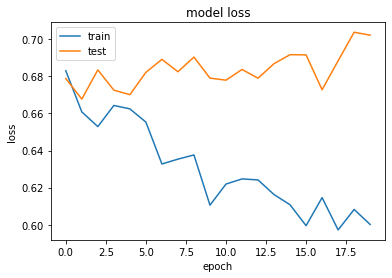

In [15]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, stratify=y)

model = create_model(
    optimizer = keras.optimizers.SGD(
        learning_rate=0.01, momentum=0.8, nesterov=False, name="SGD"
    )
)
history = model.fit(X_train, y_train, validation_split=0.1, batch_size=8, epochs=20)

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [16]:
from sklearn.metrics import accuracy_score, classification_report

y_pred = np.round(model.predict(X_test))

print(accuracy_score(y_test, y_pred))

print(classification_report(y_test, y_pred))

0.6222222222222222
              precision    recall  f1-score   support

           0       0.60      0.58      0.59        85
           1       0.64      0.66      0.65        95

    accuracy                           0.62       180
   macro avg       0.62      0.62      0.62       180
weighted avg       0.62      0.62      0.62       180



Epoch 1/10
81/81 [==============================] - 0s 2ms/step - loss: 0.7148 - accuracy: 0.4567 - val_loss: 0.6850 - val_accuracy: 0.4861
Epoch 2/10
81/81 [==============================] - 0s 1ms/step - loss: 0.6913 - accuracy: 0.5619 - val_loss: 0.6790 - val_accuracy: 0.5556
Epoch 3/10
81/81 [==============================] - 0s 992us/step - loss: 0.6830 - accuracy: 0.5789 - val_loss: 0.6742 - val_accuracy: 0.6250
Epoch 4/10
81/81 [==============================] - 0s 980us/step - loss: 0.6791 - accuracy: 0.6254 - val_loss: 0.6739 - val_accuracy: 0.6389
Epoch 5/10
81/81 [==============================] - 0s 986us/step - loss: 0.6694 - accuracy: 0.6316 - val_loss: 0.6722 - val_accuracy: 0.6389
Epoch 6/10
81/81 [==============================] - 0s 948us/step - loss: 0.6589 - accuracy: 0.6269 - val_loss: 0.6682 - val_accuracy: 0.6111
Epoch 7/10
81/81 [==============================] - 0s 999us/step - loss: 0.6588 - accuracy: 0.6378 - val_loss: 0.6662 - val_accuracy: 0.6111
Epoch 8/10

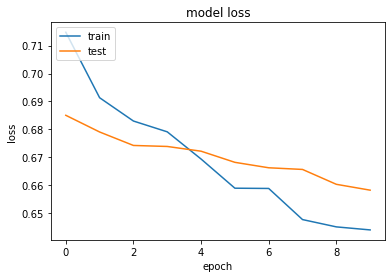

In [17]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, stratify=y)

model = create_model(optimizer="adam")
history = model.fit(X_train, y_train, validation_split=0.1, batch_size=8, epochs=10)

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [18]:
from sklearn.metrics import accuracy_score, classification_report

y_pred = np.round(model.predict(X_test))

print(accuracy_score(y_test, y_pred))

print(classification_report(y_test, y_pred))

0.6055555555555555
              precision    recall  f1-score   support

           0       0.62      0.44      0.51        85
           1       0.60      0.76      0.67        95

    accuracy                           0.61       180
   macro avg       0.61      0.60      0.59       180
weighted avg       0.61      0.61      0.59       180



The metrics are evaluated on the balanced sub-sample. The higher accuracy is only due to the model being more used to the in-frequent class. Its true test will be on the imbalanced sub-sample, where we will really measure how it discriminates. One should expect a lot lower precision for the in-frequent class.

In [19]:
from sklearn.pipeline import make_pipeline
from imblearn.pipeline import make_pipeline as imbalanced_make_pipeline
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import NearMiss
from imblearn.metrics import classification_report_imbalanced
from sklearn.model_selection import StratifiedKFold

In [20]:
sss = StratifiedKFold(n_splits=5, random_state=None, shuffle=True)

for train_index, test_index in sss.split(X_orig, y_orig):
    print(train_index)

[   1    2    3 ... 2720 2722 2723]
[   0    1    2 ... 2720 2721 2722]
[   0    3    5 ... 2721 2722 2723]
[   0    1    2 ... 2720 2721 2723]
[   0    1    2 ... 2721 2722 2723]


In [21]:
from imblearn.over_sampling import SMOTE 

sm = SMOTE(random_state=42)
X_res, y_res = sm.fit_resample(X_orig[train_index], y_orig[train_index])

Epoch 1/10
443/443 [==============================] - 1s 1ms/step - loss: 0.7031 - accuracy: 0.5401 - val_loss: 0.6933 - val_accuracy: 0.6360
Epoch 2/10
443/443 [==============================] - 0s 864us/step - loss: 0.6632 - accuracy: 0.6172 - val_loss: 0.6800 - val_accuracy: 0.6930
Epoch 3/10
443/443 [==============================] - 1s 1ms/step - loss: 0.6444 - accuracy: 0.6516 - val_loss: 0.6517 - val_accuracy: 0.7279
Epoch 4/10
443/443 [==============================] - 0s 973us/step - loss: 0.6391 - accuracy: 0.6595 - val_loss: 0.6358 - val_accuracy: 0.7408
Epoch 5/10
443/443 [==============================] - 0s 820us/step - loss: 0.6301 - accuracy: 0.6725 - val_loss: 0.6318 - val_accuracy: 0.7426
Epoch 6/10
443/443 [==============================] - 0s 1ms/step - loss: 0.6209 - accuracy: 0.6711 - val_loss: 0.6025 - val_accuracy: 0.7279
Epoch 7/10
443/443 [==============================] - 0s 1ms/step - loss: 0.6104 - accuracy: 0.6787 - val_loss: 0.5720 - val_accuracy: 0.7298


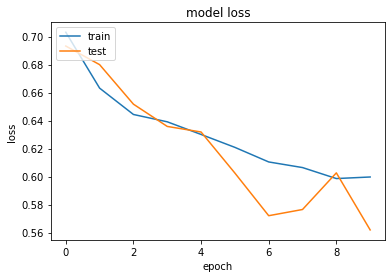

In [24]:
model = create_model(optimizer="adam")
history = model.fit(X_res, y_res, validation_data=(X_orig[test_index], y_orig[test_index]), batch_size=8, epochs=10)

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [25]:
y_pred = np.round(model.predict(X_orig[test_index]))

print(accuracy_score(y_orig[test_index], y_pred))

print(classification_report(y_orig[test_index], y_pred))

0.7077205882352942
              precision    recall  f1-score   support

           0       0.89      0.73      0.80       442
           1       0.34      0.61      0.44       102

    accuracy                           0.71       544
   macro avg       0.62      0.67      0.62       544
weighted avg       0.79      0.71      0.73       544

